# Init

In [1]:
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import numpy as np
from tkinter import *
from PIL import Image, ImageTk, ImageFont, ImageDraw
import serial
import time
from datetime import datetime
from scipy.ndimage.filters import gaussian_filter, maximum_filter
from scipy.optimize import minimize
import scipy.signal
import scipy as sc
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature
import statistics


data_dir = 'd:/Katalog 1/Science/Projekt lasery/mikroskop/mikroskop_data/raw_mikro_data/'

In [2]:
diff_cmap = plt.get_cmap('PiYG')


def cmap_array(arr, cmap, rng = 1, middle = 0):
     return cmap((arr/rng+1-middle/rng)/2)[:,:,:3]
    
    
def blur_crop(arr, sigma = 7, crop = 40):
    arr = gaussian_filter(arr, sigma=sigma)
    test = cv2.resize(arr, (arr.shape[1]+crop, arr.shape[0]+crop), interpolation = cv2.INTER_AREA)
    new = np.zeros(arr.shape, float)
    half_crop = int(crop/2)
    new = test[half_crop:-half_crop, half_crop:-half_crop]
    return new


def compare_colorchannels(arr1, arr2, ranger = 0.3):
    arr1g = cv2.cvtColor(arr1, cv2.COLOR_BGR2GRAY).astype(float)/255
    arr2g = cv2.cvtColor(arr2, cv2.COLOR_BGR2GRAY).astype(float)/255

    std_mapka = arr2g-arr1g

    fig = plt.figure(figsize = (6, 15))
    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    ax1.set_title('gray')
    ch1 = ax1.imshow(std_mapka, cmap = diff_cmap)
    norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
    ch1.set_norm(norm)

    axis = 0
    ax2.set_title('axis = 0 (B)')
    mapka2 = (arr2.astype(float)/255)[:,:,axis] - (arr1.astype(float)/255)[:,:,axis]
    ch2 = ax2.imshow(mapka2, cmap = diff_cmap)
    norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
    ch2.set_norm(norm)

    axis = 1
    ax3.set_title('axis = 1 (G)')
    mapka2 = (arr2.astype(float)/255)[:,:,axis] - (arr1.astype(float)/255)[:,:,axis]
    ch3 = ax3.imshow(mapka2, cmap = diff_cmap)
    norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
    ch3.set_norm(norm)

    axis = 2
    ax4.set_title('axis = 2 (R)')
    mapka2 = (arr2.astype(float)/255)[:,:,axis] - (arr1.astype(float)/255)[:,:,axis]
    ch4 = ax4.imshow(mapka2, cmap = diff_cmap)
    norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
    ch4.set_norm(norm)
    
    return fig


def minimize_bisection(function, arguments = [], rng = [0, 1], jumps = 10):
    jump = abs(rng[1]-rng[0])/2  # current jump
    cp = (rng[0]+rng[1])/2  # current position
#     cr = function(cp)  # current result of the function
    for i in range(0, jumps):
        # calculate results on the left and right
        args = [cp-jump] + arguments
        rl = function(*args)
        args = [cp+jump] + arguments
        rr = function(*args)
#         print('jump = %d, cp = %f, rl=%f,rr=%f'%(i, cp, rl, rr))
        if rr < rl:
            cp += jump
        else:
            cp -= jump
        jump /= 2
    return cp


def new_map(arr1, arr2):
    arr1g = cv2.cvtColor(arr1, cv2.COLOR_BGR2GRAY).astype(float)/255
    arr2g = cv2.cvtColor(arr2, cv2.COLOR_BGR2GRAY).astype(float)/255
    
    arr1degg = degradient(arr1g)
    arr2degg = degradient(arr2g)
    
    return arr2degg-arr1degg


def estimate_gradient(img, sig = 300):
    blur = blur_crop(img, sigma = sig)
    return blur.max()/blur.min()


def check_factor(factor, image, grad):
    img_c = image.copy() - grad*factor + grad.mean()*factor
    return estimate_gradient(img_c)


def degradient_old(img, sig = 300):
    grad = blur_crop(img, sigma=sig)
    
    factor = minimize_bisection(check_factor, arguments = [img.copy(), grad], rng = [0, 4], jumps = 7)
    return img.copy() - grad*factor + grad.mean()*factor


def degradient(img, resize = 10, sig = 300, jumps = 8):
    sy = int(img.shape[0]/resize)
    sx = int(img.shape[1]/resize)
    resized = cv2.resize(img, (sx, sy), interpolation = cv2.INTER_AREA)
    grad = blur_crop(resized, sigma=int(sig/resize), crop = int(40/resize))
    
    factor = minimize_bisection(check_factor, arguments = [resized.copy(), grad], rng = [0, 4], jumps = jumps)
    # recalculate gradient using full unresized image
    grad = blur_crop(img, sigma=sig)
    return img.copy() - grad*factor + grad.mean()*factor


def advanced_map(img_minus, img_plus, sg = 4, degrad_size = 10, maxi = 2):
    # convert to grayscale
    arrPg = cv2.cvtColor(img_plus, cv2.COLOR_BGR2GRAY).astype(float)/255
    arrMg = cv2.cvtColor(img_minus, cv2.COLOR_BGR2GRAY).astype(float)/255
    
    # gauss if necessary
    if (sg>0):
        arrPg = gaussian_filter(arrPg, sigma=sg)
        arrMg = gaussian_filter(arrMg, sigma=sg)
    
    # degradient if necessary
    if (degrad_size>0):
        arrPg = degradient(arrPg, resize = degrad_size)
        arrMg = degradient(arrMg, resize = degrad_size)
        
    # maxi filter if necessary (good for eliminating birefringence)
    if maxi>0:
        arrPg = -maximum_filter(-arrPg, maxi)
        arrMg = -maximum_filter(-arrMg, maxi)
        
    # mapka
    mapka = arrPg-arrMg
#     mapka = mapka-mapka.mean()
    
    # get domain threshold
    min1, max1 = get_minmax(get_distribution(mapka))
    ranger = max([abs(min1), max1])*0.3
    
    np.save('temp.npy', mapka)
    
    return mapka, ranger
    
    
def get_distribution(mapka):
    flat_dif = mapka.copy()
    flat_dif = flat_dif.flatten()
    flat_dif.sort()
    return flat_dif


def get_minmax(flat_dif, percent = 0.01):   
    count = flat_dif.shape[0]

    minval = flat_dif[int(count*percent)]
    maxval = flat_dif[-int(count*percent)]

    return minval, maxval


def load_pair_images(pair):
    img_plus = np.load(data_dir + pair[0])
    img_mins = np.load(data_dir + pair[1])
    
    return img_mins, img_plus


def plot_pair(pair):
    img_plus = np.load(data_dir + pair[0])
    img_mins = np.load(data_dir + pair[1])
    
    fig = plt.figure(figsize = (16, 8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.imshow(cv2.cvtColor(img_plus, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img_mins, cv2.COLOR_BGR2RGB))
    
    return fig


def dechannel(im, ch):
    im[:,:,0] = im[:,:,ch]
    im[:,:,1] = im[:,:,ch]
    im[:,:,2] = im[:,:,ch]
    return im


def get_linear_grad(arr, ch, norm = False, sav = 0):
    grad = ((arr).astype(float)/255)[:,:,ch].sum(axis = 0)/arr.shape[1]
    grad = grad[2:-2]
    if sav > 0:
        grad = sc.signal.savgol_filter(x=grad, window_length=sav, polyorder=3)
    
    if norm == True:
        grad -= grad.min()
        grad /= grad.max()
#         grad /= grad.mean()
    return grad


def mov_avg(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def get_bgr_channels(img_mins, img_plus, cutoff = 6, sg = 2, mx = 2):
    '''
    this function calculates maps for each channel (called mapkaB, mapkaG and mapkaR)
    without using degradient, it returns all gradients and the red channel map
    '''
    cm = dechannel(img_mins.copy(), 0)
    cp = dechannel(img_plus.copy(), 0)
    mapkaB, rangerB = advanced_map(cm, cp, sg = sg, maxi = mx, degrad_size = 0)
    lingradB = mapkaB.sum(axis = 0)/mapkaB.shape[0]

    cm = dechannel(img_mins.copy(), 1)
    cp = dechannel(img_plus.copy(), 1)
    mapkaG, rangerG = advanced_map(cm, cp, sg = sg, maxi = mx, degrad_size = 0)
    lingradG = mapkaG.sum(axis = 0)/mapkaG.shape[0]

    cm = dechannel(img_mins.copy(), 2)
    cp = dechannel(img_plus.copy(), 2)
    mapkaR, rangerR = advanced_map(cm, cp, sg = sg, maxi = mx, degrad_size = 0)
    lingradR = mapkaR.sum(axis = 0)/mapkaR.shape[0]
    
    return lingradB[cutoff:-cutoff], lingradG[cutoff:-cutoff], lingradR[cutoff:-cutoff], mapkaR



def PolyCoefficients(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """
    o = len(coeffs)
    y = 0
    for i in range(o):
        y += coeffs[i]*x**i
    return y


def get_channel_map(img_mins, img_plus, cutoff = 6, factor = 1, sg = 2, mx = 2):
    lingradB, lingradG, lingradR, mapkaR = get_bgr_channels(img_mins, img_plus, cutoff = cutoff, sg = sg, mx = mx)
    
    diffRG = lingradR-lingradG
    diffRB = lingradR-lingradB
    diff = (diffRG+diffRB)/2

    poly = list(np.polyfit(range(cutoff, len(diff)+cutoff), diff, 3))
    poly.reverse()
    arr_x = np.asarray(range(0, img_mins.shape[1]))
    fitDif = PolyCoefficients(arr_x, poly)
    
    final_map = mapkaR+fitDif*factor
    return final_map


def baseline_mapping(img_min, img_pls, baseline_min, baseline_pls, sigma = 2, ch = 2):    
    img_min_g = dechannel(img_min.copy(), ch)
    img_pls_g = dechannel(img_pls.copy(), ch)
    
    b_min_g = dechannel(baseline_min.copy(), ch)
    b_pls_g = dechannel(baseline_pls.copy(), ch)
    
    img_min_g = (cv2.cvtColor(img_min_g, cv2.COLOR_BGR2GRAY)).astype(float)/255
    img_pls_g = (cv2.cvtColor(img_pls, cv2.COLOR_BGR2GRAY)).astype(float)/255
    
    b_min_g = (cv2.cvtColor(baseline_min, cv2.COLOR_BGR2GRAY)).astype(float)/255
    b_pls_g = (cv2.cvtColor(baseline_pls, cv2.COLOR_BGR2GRAY)).astype(float)/255
    
    for i in range(0, 2):
        img_min_g = gaussian_filter(img_min_g, sigma=sigma)
        img_pls_g = gaussian_filter(img_pls_g, sigma=sigma)
        b_min_g = gaussian_filter(b_min_g, sigma=sigma)
        b_pls_g = gaussian_filter(b_pls_g, sigma=sigma)
    
    img_min_g = img_min_g - b_min_g
    img_pls_g = img_pls_g - b_pls_g
    
    return img_pls_g-img_min_g

## Areal functions

In [2]:
def get_coordinates_from_name(name):
    if name.find('x=') >= 0:
        x = name[name.find('x=')+2:name.find('y=')]
        y = name[name.find('y=')+2:name.find(').npy')]
        
    if name.find(' X') >= 0 and name.find(' Y') >= 0:
        x = name[name.find(' X')+2:name.find(' X')+2+3]
        y = name[name.find(' Y')+2:name.find(' Y')+2+3]
        
    return float(x), float(y)


def merge_arrays(arr1, crd1, arr2, crd2, crop=5):
    hor1 = crd1[1] + arr1.shape[1]
    ver1 = crd1[0] + arr1.shape[0]

    hor2 = crd2[1] + arr2.shape[1]
    ver2 = crd2[0] + arr2.shape[0]

    hor = int(max([hor1, hor2]))
    ver = int(max([ver1, ver2]))

    combine = np.zeros((ver, hor, 3), np.uint8)

    combine[crd1[0] + crop:arr1.shape[0] + crd1[0] - crop, crd1[1] +
            crop:arr1.shape[1] + crd1[1] - crop] = arr1[crop:-crop, crop:-crop]
    combine[crd2[0] + crop:arr2.shape[0] + crd2[0] - crop, crd2[1] +
            crop:arr2.shape[1] + crd2[1] - crop] = arr2[crop:-crop, crop:-crop]

    return combine


def combine_in_folder(area):
    files = os.listdir(data_dir + area)
    for file in files:
        # get coordinates and recalculate to pixels
        x, y = get_coordinates_from_name(file)
        x = int(x*1000 * scale_px[obj]/scale_um[obj])
        y = int(y*1000 * scale_px[obj]/scale_um[obj])
        img = np.load(data_dir + area + '/' + file)
#         img = cv2.putText(img, '%2.2f, %2.2f'%(x, y), (80, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (235,20,20), 3, cv2.LINE_AA)

        if file == files[0]:
            combine = img.copy()
        else:
            combine = merge_arrays(combine, [0, 0], img, [y, x], crop = 5)
    return combine


def combine_filelist(filelist):
    for file in filelist:
        # get coordinates and recalculate to pixels
        x, y = get_coordinates_from_name(file)
        x = int(x*1000 * scale_px[obj]/scale_um[obj])
        y = int(y*1000 * scale_px[obj]/scale_um[obj])
        img = np.load(file)
#         img = cv2.putText(img, '%2.2f, %2.2f'%(x, y), (80, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (235,20,20), 3, cv2.LINE_AA)

        if file == filelist[0]:
            combine = img.copy()
        else:
            combine = merge_arrays(combine, [0, 0], img, [y, x], crop = 5)
    return combine

            
scale_um = {'X5': 500, 'X10': 200, 'X20': 100, 'X50': 50, 'X100': 20}
scale_px = {'X5': 200, 'X10': 160, 'X20': 160, 'X50': 200, 'X100': 160}
obj = 'X5'

# Main

In [5]:
data_dir = 'raw_mikro_data/'

In [9]:
folder = 'test'
obj = 'X5'
polrot = 10
sign = -1

if sign == -1:
    polrot = -polrot
    pol_name = 'M'
else:
    pol_name = 'P'

files = os.listdir(data_dir + '%s'%folder)
files_m = [data_dir + '%s/'%folder + f for f in files if f.find('frame_mapping P%d.0'%(90+polrot)) >= 0]
len(files_m)

9

In [10]:
combine = combine_filelist(files_m)
combine = cv2.cvtColor(combine, cv2.COLOR_BGR2RGB)

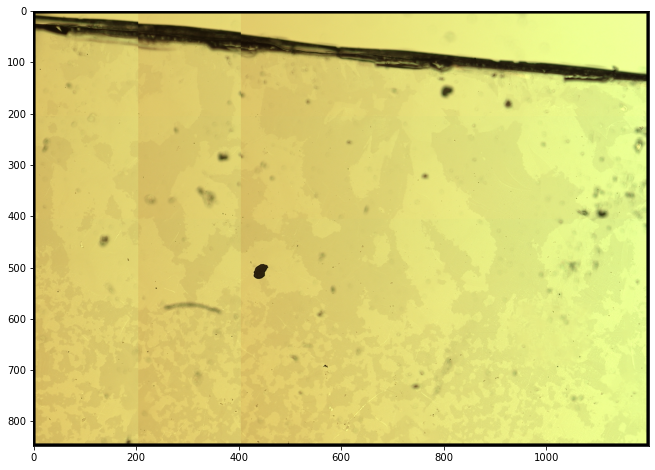

In [11]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

ax.imshow(combine)

In [12]:
scale_h = 40
scale_w = scale_px[obj]

scale_x = 20
scale_y = combine.shape[0] - 20 - scale_h

combine_scale = cv2.rectangle(combine.copy(), (scale_x, scale_y),
                             (scale_x + scale_w, scale_y + scale_h),
                             (255, 255, 255), -1)

font = cv2.FONT_HERSHEY_DUPLEX
text = '%d um'%scale_um[obj]
(label_width, label_height), baseline = cv2.getTextSize(text, font, 1, 2)
org = (int(scale_x + 0.5*scale_w-label_width/2), int(scale_y + 0.5*scale_h+label_height/2))
combine_scale = cv2.putText(combine_scale, text, org, font, 1, (0, 0, 0), 2, cv2.LINE_AA)

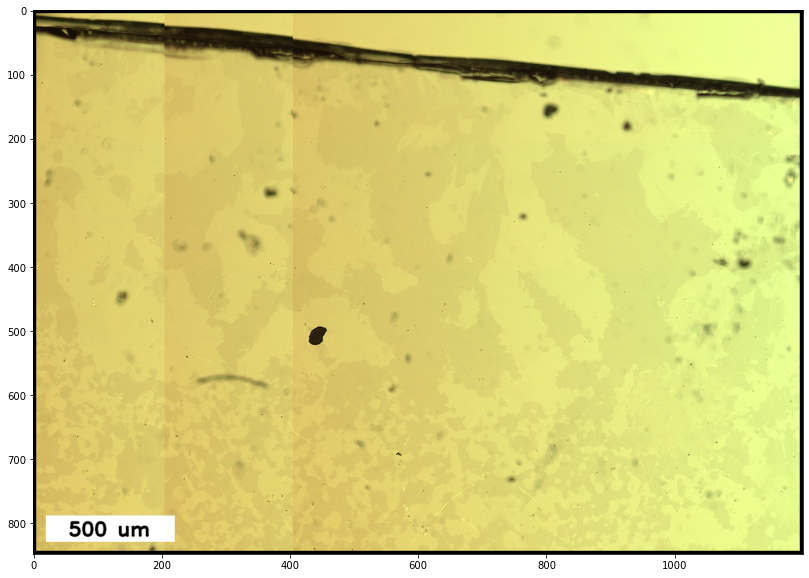

In [13]:
fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(111)

ax.imshow(combine_scale)

In [47]:
cv2.imwrite(data_dir + 'maps/%s_%s.jpg'%(folder, pol_name), cv2.cvtColor(combine_scale, cv2.COLOR_RGB2BGR))

True

# Full auto combinator

In [14]:
def get_coordinates_from_name(name):
    if name.find('x=') >= 0:
        x = name[name.find('x=')+2:name.find('y=')]
        y = name[name.find('y=')+2:name.find(').npy')]
        
    if name.find(' X') >= 0 and name.find(' Y') >= 0:
        x = name[name.find(' X')+2:name.find(' X')+2+3]
        y = name[name.find(' Y')+2:name.find(' Y')+2+3]
        
    return float(x), float(y)


def merge_arrays(arr1, crd1, arr2, crd2, crop=5):
    hor1 = crd1[1] + arr1.shape[1]
    ver1 = crd1[0] + arr1.shape[0]

    hor2 = crd2[1] + arr2.shape[1]
    ver2 = crd2[0] + arr2.shape[0]

    hor = int(max([hor1, hor2]))
    ver = int(max([ver1, ver2]))

    combine = np.zeros((ver, hor, 3), np.uint8)

    combine[crd1[0] + crop:arr1.shape[0] + crd1[0] - crop, crd1[1] +
            crop:arr1.shape[1] + crd1[1] - crop] = arr1[crop:-crop, crop:-crop]
    combine[crd2[0] + crop:arr2.shape[0] + crd2[0] - crop, crd2[1] +
            crop:arr2.shape[1] + crd2[1] - crop] = arr2[crop:-crop, crop:-crop]

    return combine


def combine_filelist(filelist):
    for file in filelist:
        # get coordinates and recalculate to pixels
        x, y = get_coordinates_from_name(file)
        x = int(x*1000 * scale_px[obj]/scale_um[obj])
        y = int(y*1000 * scale_px[obj]/scale_um[obj])
        img = np.load(file)
#         img = cv2.putText(img, '%2.2f, %2.2f'%(x, y), (80, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (235,20,20), 3, cv2.LINE_AA)

        if file == filelist[0]:
            combine = img.copy()
        else:
            combine = merge_arrays(combine, [0, 0], img, [y, x], crop = 5)
    return combine

In [39]:
def combine_by_date(date_str, obj = 'X5', sname = 'jamnik'):
    scale_um = {'X5': 500, 'X10': 200, 'X20': 100, 'X50': 50, 'X100': 20}
    scale_px = {'X5': 200, 'X10': 160, 'X20': 160, 'X50': 200, 'X100': 160}
    data_dir = 'raw_mikro_data/'
    
    files = [f for f in os.listdir(data_dir) if f.find(date_str)>=0]
    
    frame_files = [f for f in files if f.find('frame_mapping')>=0]
    polars = list(set([f[f.rfind(' P')+1:f.rfind(' X')] for f in frame_files]))

    for pol in polars:
        combine = combine_filelist([data_dir + f for f in frame_files if f.find(pol)>=0])

        scale_h = 40
        scale_w = scale_px[obj]

        scale_x = 20
        scale_y = combine.shape[0] - 20 - scale_h

        combine_scale = cv2.rectangle(combine.copy(), (scale_x, scale_y),
                                     (scale_x + scale_w, scale_y + scale_h),
                                     (255, 255, 255), -1)

        font = cv2.FONT_HERSHEY_DUPLEX
        text = '%d um'%scale_um[obj]
        (label_width, label_height), baseline = cv2.getTextSize(text, font, 1, 1)
        org = (int(scale_x + 0.5*scale_w-label_width/2), int(scale_y + 0.5*scale_h+label_height/2))
        combine_scale = cv2.putText(combine_scale, text, org, font, 1, (0, 0, 0), 1, cv2.LINE_AA)
        
        cv2.imwrite(data_dir + 'maps/map_of_%s_%s_%s.jpg'%(sname, date_str, pol), combine_scale)

In [40]:
combine_by_date('29-10-2021 12.52.36')

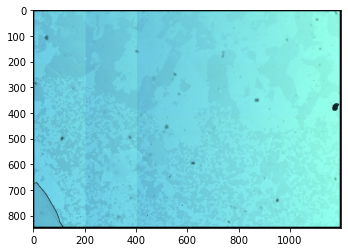

In [26]:
plt.imshow(combine)

In [59]:
combine2 = combine.copy()

combine2 = (combine2*0).astype(np.uint8)
# combine2 = combine2.astype(np.uint8)

In [60]:
combine2.max()

0